## This Notebook build two BERT neural networks to solve NLP Multi-class Prediction problem with imbalance data. Pre-trained BERT models are loaded from TensorFlow Hub.
### 1. Small Bert:small_bert/bert_en_uncased_L-2_H-512_A-8/1, 2 hidden layers. Target: 11 scores. Model trainable = True.
### 2. Bert_Base: bert_en_uncased_L-12_H-768_A-12/4, 12 hidden layers. Target: 3 classes: 0: Score 0-5; 1: Score 6-8, 2: Score 9-10. Model trainable = True.

## Data is downloaded from this public GitHub repo:

https://github.com/MarletteFunding/marlette-ds-challenge2

## **1. Small BERT**

### It uses L=2 hidden layers (i.e., Transformer blocks), a hidden size of H=512, and A=8 attention heads

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
path='/content/drive/My Drive/Data_Sets/'
df_train = pd.read_csv(path+'NLP_task_train.csv.zip',header=0,index_col=0,compression='infer')
df_validate = pd.read_csv(path+'NLP_task_validate.csv.zip',header=0,index_col=0,compression='infer')

In [ ]:
df_train.isnull().sum()

DOCUMENT_ID            0
SENTENCE_ID            0
SENTENCE              21
SENTENCE_START_POS     0
SENTENCE_END_POS       0
SCORE                  0
dtype: int64

In [ ]:
#Remove the missing data 
df_train = df_train.dropna()

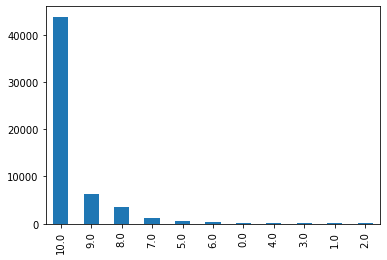

In [ ]:
# Visualize SCORE distribution, total 11 scores, majority SCORE = 10
df_train['SCORE'].value_counts().plot(kind = 'bar')

In [ ]:
df_validate.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              4
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 1
dtype: int64

In [ ]:
df_validate = df_validate.dropna()

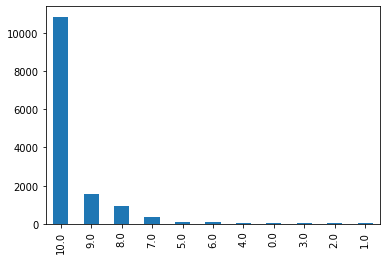

In [ ]:
df_validate['SCORE'].value_counts().plot(kind = 'bar')

In [ ]:
df_train1 = df_train[['DOCUMENT_ID', 'SCORE', 'SENTENCE']]


In [ ]:
df_train1['SENTENCE'] = df_train1.groupby(['DOCUMENT_ID'])['SENTENCE'].transform(lambda x:''.join(x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_train1 = df_train1.drop_duplicates()

In [ ]:
df_train1.head()

,DOCUMENT_ID,SCORE,SENTENCE
0,583306034,10.0,The whole process went smooth and I am thankfu...
2,584193040,10.0,service
3,584203035,10.0,Thanks!I paid off a best egg I had in the past...
4,584200037,10.0,"Thank you!Ease of use, fast customer service, ..."
6,584204033,8.0,Ease and quickness of funding the loan


In [ ]:
df_train1.shape

(39562, 3)

In [ ]:
df_pred = df_validate[['DOCUMENT_ID', 'SCORE', 'SENTENCE']]

In [ ]:
df_pred['SENTENCE'] = df_pred.groupby(['DOCUMENT_ID'])['SENTENCE'].transform(lambda x:''.join(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_pred = df_pred.drop_duplicates()

In [ ]:
df_pred.head()

,DOCUMENT_ID,SCORE,SENTENCE
7,584207033,10.0,The loan process was super easy
10,584199033,9.0,The process was quick and easy!
13,591377035,10.0,were in my bank within just a few days from th...
25,34211545,10.0,Very expensive dental work and debt consolidat...
26,34211856,10.0,thanks againjust the quick service provided to...


In [ ]:
df_train1 = pd.get_dummies(df_train1,columns=['SCORE'])

In [ ]:
df_test = pd.get_dummies(df_pred,columns=['SCORE'])  # change df_pred as df_test, so we can use df_pred later

In [ ]:
df_train1.head()

,DOCUMENT_ID,SENTENCE,SCORE_0.0,SCORE_1.0,SCORE_2.0,SCORE_3.0,SCORE_4.0,SCORE_5.0,SCORE_6.0,SCORE_7.0,SCORE_8.0,SCORE_9.0,SCORE_10.0
0,583306034,The whole process went smooth and I am thankfu...,0,0,0,0,0,0,0,0,0,0,1
2,584193040,service,0,0,0,0,0,0,0,0,0,0,1
3,584203035,Thanks!I paid off a best egg I had in the past...,0,0,0,0,0,0,0,0,0,0,1
4,584200037,"Thank you!Ease of use, fast customer service, ...",0,0,0,0,0,0,0,0,0,0,1
6,584204033,Ease and quickness of funding the loan,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
!pip install texthero

In [ ]:
!pip install tensorflow-text

In [ ]:
!pip install tf-models-official

In [ ]:
import texthero as hero
from texthero import preprocessing

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization 

In [ ]:
# before feeding the data to the model, we will clean it a bit
clean_text_bert_pipeline = [
               preprocessing.remove_urls, # remove urls
               preprocessing.remove_diacritics,
               preprocessing.remove_whitespace  # remove any extra spaces
               ]
train_bert = hero.clean(df_train1['SENTENCE'], clean_text_bert_pipeline)
test_bert = hero.clean(df_test['SENTENCE'], clean_text_bert_pipeline)

In [ ]:
# create targets
labels = ['SCORE_0.0','SCORE_1.0','SCORE_2.0','SCORE_3.0','SCORE_4.0','SCORE_5.0','SCORE_6.0','SCORE_7.0','SCORE_8.0','SCORE_9.0','SCORE_10.0']
ytrain = df_train1[labels]
ytest = df_test[labels]

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_bert, ytrain, test_size=0.20, random_state=32)

In [ ]:
# creating tensorflow dataset
# Preparaing the data to feed into the model
batch_size = 32
seed = 42

#train_ds = tf.data.Dataset.from_tensor_slices((train_bert.values, y_train.values)).shuffle(50000).batch(batch_size)
#test_ds = tf.data.Dataset.from_tensor_slices((test_bert.values, y_test.values)).shuffle(50000).batch(batch_size)
train_ds = tf.data.Dataset.from_tensor_slices((x_train.values, y_train.values)).shuffle(40000).batch(batch_size) #size 39562
vali_ds = tf.data.Dataset.from_tensor_slices((x_test.values, y_test.values)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_bert.values, ytest.values)).shuffle(10000).batch(batch_size)  # size 9891

In [ ]:
for train_batch in train_ds.take(1):
  print(train_batch[:2])

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Simple application and pre-approval process with options.',
       b'Real people in customer service.Easy process.Fast.',
       b'Very easy and fast', b'Making my payments on time',
       b'Outstanding customer service', b'Fast & easy!',
       b'My reason is that your company took my application into Consideration',
       b'Simple, quick process & funding.',
       b'Very easy and quick to apply and receive loan, rates are good.',
       b'Fast and easy', b'Being a responsible person',
       b'Ease of doing business with', b'Promptness!',
       b'Fast, smooth and easy!',
       b'Customer service was great.They were very courteous',
       b'Smooth transition from application to funding.Excellent customer service!',
       b'The process was fast and easy.',
       b'drawn outThe process was not tediousIt was done in an expeditious and efficient manner.',
       b'Ease of applying',
       b'The ease and time it took to obtai

### Loading the models form tensorflow hub

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
#tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'

tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
# create keras model 
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')  # small BERT
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(500, activation='relu')(net)
  #net = tf.keras.layers.Dense(11, activation= "sigmoid" , name='classifier')(net)
  net = tf.keras.layers.Dense(11, activation= "softmax" , name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()   # this cell can't work for Bert_base! Only work for small Bert!
classifier_model.summary()

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.metrics.BinaryAccuracy(), tf.metrics.AUC(multi_label=True)]

In [ ]:
#epochs = 20
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# compile the model
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
#callbacks = [tf.keras.callbacks.ModelCheckpoint('best_bert_model', save_best_only=True),
#             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]

In [ ]:
# train the model
bert_history = classifier_model.fit(train_ds, 
                               #validation_split=0.2, #`validation_split` is only supported for Tensors or NumPy arrays
                               validation_data=vali_ds, 
                               epochs = epochs) 
                               #callbacks = callbacks)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning:

"`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"



990/990 [==============================] - 155s 151ms/step - loss: 0.1778 - binary_accuracy: 0.9537 - auc: 0.6496 - val_loss: 0.1148 - val_binary_accuracy: 0.9608 - val_auc: 0.7719
Epoch 2/5
990/990 [==============================] - 150s 151ms/step - loss: 0.1132 - binary_accuracy: 0.9612 - auc: 0.7985 - val_loss: 0.1124 - val_binary_accuracy: 0.9614 - val_auc: 0.8079
Epoch 3/5
990/990 [==============================] - 149s 151ms/step - loss: 0.1094 - binary_accuracy: 0.9622 - auc: 0.8208 - val_loss: 0.1121 - val_binary_accuracy: 0.9615 - val_auc: 0.7993
Epoch 4/5
990/990 [==============================] - 149s 151ms/step - loss: 0.1072 - binary_accuracy: 0.9627 - auc: 0.8410 - val_loss: 0.1124 - val_binary_accuracy: 0.9618 - val_auc: 0.8001
Epoch 5/5
990/990 [==============================] - 150s 152ms/step - loss: 0.1056 - binary_accuracy: 0.9631 - auc: 0.8530 - val_loss: 0.1125 - val_binary_accuracy: 0.9617 - val_auc: 0.8024


In [ ]:
classifier_model.save('/content/drive/My Drive/Data_Sets/bert_model.h5')

In [ ]:
bert_history.history

{'auc': [0.6495897769927979,
  0.7984591126441956,
  0.8208013772964478,
  0.8410141468048096,
  0.8530464172363281],
 'binary_accuracy': [0.9536765217781067,
  0.9612018465995789,
  0.9621558785438538,
  0.9626815319061279,
  0.9630717039108276],
 'loss': [0.1777532696723938,
  0.1131839007139206,
  0.10944484919309616,
  0.10722850263118744,
  0.10558941960334778],
 'val_auc': [0.7719270586967468,
  0.8079364895820618,
  0.7992675304412842,
  0.8000633120536804,
  0.8023903369903564],
 'val_binary_accuracy': [0.9607780575752258,
  0.9614444375038147,
  0.9614672660827637,
  0.9617542028427124,
  0.9616624116897583],
 'val_loss': [0.11481066048145294,
  0.11235065013170242,
  0.11205367743968964,
  0.11239393800497055,
  0.11245863884687424]}

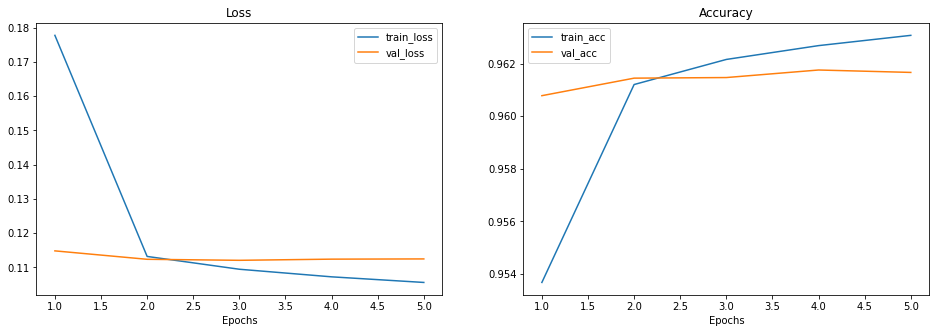

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize = (16,5))
epochs = [i for i in range(1,6)]
ax[0].plot(epochs, bert_history.history['loss'], label = 'train_loss');
ax[0].plot(epochs, bert_history.history['val_loss'], label = 'val_loss');
ax[0].set_title("Loss");
ax[0].set_xlabel("Epochs")
ax[0].legend();
ax[1].plot(epochs, bert_history.history['binary_accuracy'], label = 'train_acc');
ax[1].plot(epochs, bert_history.history['val_binary_accuracy'], label = 'val_acc');
ax[1].set_title("Accuracy");
ax[1].set_xlabel("Epochs")
ax[1].legend();


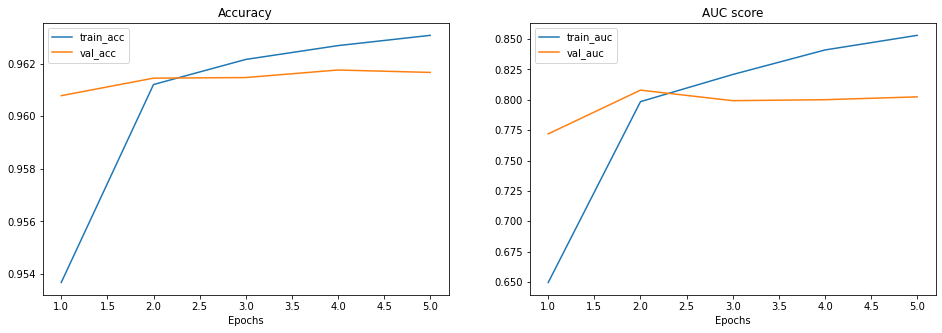

In [ ]:
# performance curve
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize = (16,5))
epochs = [i for i in range(1,6)]
ax[0].plot(epochs, bert_history.history['binary_accuracy'], label = 'train_acc');
ax[0].plot(epochs, bert_history.history['val_binary_accuracy'], label = 'val_acc');
ax[0].set_title("Accuracy");
ax[0].set_xlabel("Epochs")
ax[0].legend();

ax[1].plot(epochs, bert_history.history['auc'], label = 'train_auc');
ax[1].plot(epochs, bert_history.history['val_auc'], label = 'val_auc');
ax[1].set_title("AUC score");
ax[1].set_xlabel("Epochs")
ax[1].legend();


In [ ]:
# load the best model
#bert_model = tf.keras.models.load_model('best_bert_model', compile = False)

In [ ]:
# compile the model
classifier_model.compile(optimizer=optimizer, loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=metrics)

In [ ]:
loss, accuracy,auc = classifier_model.evaluate(test_ds)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning:

"`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"



310/310 [==============================] - 25s 79ms/step - loss: 0.1110 - binary_accuracy: 0.9616 - auc: 0.8137


In [ ]:
import numpy as np
print(f"Accuracy: {np.round(accuracy,4)}")
print(f"AUC: {np.round(auc,4)}")
print(f"Logloss: {np.round(loss,4)}")

Accuracy: 0.9616
AUC: 0.8137
Logloss: 0.111


In [ ]:
ypred = classifier_model.predict(test_ds)
ypred = np.argmax(ypred, axis=1)
ytest = np.argmax(ytest.values, axis=1)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['0','1','2','3','4','5','6','7','8','9','10']
print(classification_report(ytest, ypred, target_names = target_names))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00        66
           6       0.00      0.00      0.00        63
           7       0.04      0.00      0.01       221
           8       0.06      0.05      0.05       679
           9       0.12      0.00      0.01      1180
          10       0.77      0.94      0.85      7612

    accuracy                           0.73      9891
   macro avg       0.09      0.09      0.08      9891
weighted avg       0.61      0.73      0.66      9891



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, ypred)
print(cm)

[[   0    0    0    0    0    0    0    0    1    0   21]
 [   0    0    0    0    0    0    0    0    0    0    7]
 [   0    0    0    0    0    0    0    1    0    0    9]
 [   0    0    0    0    0    0    0    0    0    0   14]
 [   0    0    0    0    0    0    0    0    1    0   16]
 [   0    0    0    0    0    0    0    0    2    0   64]
 [   0    0    0    0    0    0    0    0    2    1   60]
 [   0    0    0    0    0    0    0    1   14    2  204]
 [   0    0    0    0    0    0    0    2   31    4  642]
 [   0    0    0    0    1    3    3    5   66    5 1097]
 [   0    0    0    0    0   15    9   17  379   29 7163]]


In [ ]:
df_pred['Prediction'] = ypred

In [ ]:
df_pred['Evaluation'] = [[1]*11]*len(ypred)

In [ ]:
for index, row in df_pred.iterrows():
  df_pred['Evaluation'][index] = cm[int(row.SCORE)]   # SCORE has encoded, need to use previous df--change name

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_pred.head()

,DOCUMENT_ID,SCORE,SENTENCE,Prediction,Evaluation
7,584207033,10.0,The loan process was super easy,8,"[0, 0, 0, 0, 0, 15, 9, 17, 379, 29, 7163]"
10,584199033,9.0,The process was quick and easy!,10,"[0, 0, 0, 0, 1, 3, 3, 5, 66, 5, 1097]"
13,591377035,10.0,were in my bank within just a few days from th...,10,"[0, 0, 0, 0, 0, 15, 9, 17, 379, 29, 7163]"
25,34211545,10.0,Very expensive dental work and debt consolidat...,10,"[0, 0, 0, 0, 0, 15, 9, 17, 379, 29, 7163]"
26,34211856,10.0,thanks againjust the quick service provided to...,10,"[0, 0, 0, 0, 0, 15, 9, 17, 379, 29, 7163]"


In [ ]:
df_pred.tail()

,DOCUMENT_ID,SCORE,SENTENCE,Prediction,Evaluation
70625,689811033,8.0,The speed in which the process was taken was e...,10,"[0, 0, 0, 0, 0, 0, 0, 2, 31, 4, 642]"
70645,689884033,10.0,Quick and easy with a low loan interest rate i...,10,"[0, 0, 0, 0, 0, 15, 9, 17, 379, 29, 7163]"
70646,689562033,5.0,The prompt decision,10,"[0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 64]"
70652,689568034,10.0,paying bills,10,"[0, 0, 0, 0, 0, 15, 9, 17, 379, 29, 7163]"
70655,689550034,10.0,It was quick and easy process,10,"[0, 0, 0, 0, 0, 15, 9, 17, 379, 29, 7163]"


## **2. BERT_Base (uncased)**
### Model trainable = True

### It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. Input sentences are cased.

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.7.0


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 506), reused 1388 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 17.64 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

     |████████████████████████████████| 8.0 MB 11.8 MB/s 
     |████████████████████████████████| 205 kB 77.3 MB/s 
     |████████████████████████████████| 15.7 MB 59.3 MB/s 
     |████████████████████████████████| 11.3 MB 60.6 MB/s 
     |████████████████████████████████| 280 kB 78.7 MB/s 
     |████████████████████████████████| 99 kB 13.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 213 kB 82.0 MB/s 
     |████████████████████████████████| 4.0 MB 70.9 MB/s 
     |████████████████████████████████| 1.1 MB 66.8 MB/s 
     |████████████████████████████████| 352 kB 80.3 MB/s 
     |████████████████████████████████| 1.2 MB 70.2 MB/s 
     |████████████████████████████████| 11.2 MB 65.4 MB/s 
     |████████████████████████████████| 47.7 MB 1.3 MB/s 
     |████████████████████████████████| 596 kB 50.9 MB/s 
     |████████████████████████████████| 4.3 MB 58.9 MB/s 
     |████████████████████████████████| 75 kB 5.7 MB/s 
     |████████

In [ ]:
!pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 9.6 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
import tensorflow_text as text

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split



## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd 
path='/content/drive/My Drive/Data_Sets/'
df_train = pd.read_csv(path+'NLP_task_train.csv.zip',header=0,index_col=0,compression='infer')
df_validate = pd.read_csv(path+'NLP_task_validate.csv.zip',header=0,index_col=0,compression='infer')

In [ ]:
df_train.isnull().sum()

DOCUMENT_ID            0
SENTENCE_ID            0
SENTENCE              21
SENTENCE_START_POS     0
SENTENCE_END_POS       0
SCORE                  0
dtype: int64

In [ ]:
!pip install pandas --upgrade

In [ ]:
#Remove the missing data 
df_train = df_train.dropna()

In [ ]:
df_validate.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              4
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 1
dtype: int64

In [ ]:
df_validate = df_validate.dropna()

In [ ]:
df_train1 = df_train[['DOCUMENT_ID', 'SCORE', 'SENTENCE']]


In [ ]:
df_train1['SENTENCE'] = df_train1.groupby(['DOCUMENT_ID'])['SENTENCE'].transform(lambda x:''.join(x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_train1 = df_train1.drop_duplicates()
df_train1.shape

(39562, 3)

In [ ]:
df_train1.head()

,DOCUMENT_ID,SCORE,SENTENCE
0,583306034,10.0,The whole process went smooth and I am thankfu...
2,584193040,10.0,service
3,584203035,10.0,Thanks!I paid off a best egg I had in the past...
4,584200037,10.0,"Thank you!Ease of use, fast customer service, ..."
6,584204033,8.0,Ease and quickness of funding the loan


In [ ]:
df_pred = df_validate[['DOCUMENT_ID', 'SCORE', 'SENTENCE']]

In [ ]:
df_pred['SENTENCE'] = df_pred.groupby(['DOCUMENT_ID'])['SENTENCE'].transform(lambda x:''.join(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_pred = df_pred.drop_duplicates()
df_pred.shape

(9891, 3)

In [ ]:
df_train1['SCORE'] = df_train1['SCORE'].astype(int)
df_pred['SCORE'] = df_pred['SCORE'].astype(int)


###Combine 11 Scores into 3 classes: 0: 0-5, 1: 6-8, 2: 9-10

In [ ]:
df_train1['classes'] = df_train1['SCORE'].apply(lambda x: 0 if x<6 else(1 if 6 <=x<9 else 2))
df_pred['classes'] = df_pred['SCORE'].apply(lambda x: 0 if x<6 else(1 if 6<=x<9 else 2))

### Pandas encode target (one hot)

In [ ]:
df_train1 = pd.get_dummies(df_train1,columns=['classes'])
df_pred = pd.get_dummies(df_pred,columns=['classes'])

In [ ]:
df_train1.head(2)

,DOCUMENT_ID,SCORE,SENTENCE,classes_0,classes_1,classes_2
0,583306034,10,The whole process went smooth and I am thankfu...,0,0,1
2,584193040,10,service,0,0,1


## Create tf.data.Datasets for Training and Evaluation

In [ ]:
labels = ['classes_0','classes_1','classes_2']
#labels = ['SCORE_0','SCORE_1','SCORE_2','SCORE_3','SCORE_4','SCORE_5','SCORE_6','SCORE_7','SCORE_8','SCORE_9','SCORE_10']
#y = df_train1[labels]
ytest = df_pred[labels]

In [ ]:
train_df, val_df = train_test_split(df_train1, random_state = 42, train_size = 0.8, stratify = df_train1[labels] )
print(train_df.shape, val_df.shape)

(31649, 6) (7913, 6)


In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['SENTENCE'].values, train_df[labels].values))
  val_data = tf.data.Dataset.from_tensor_slices((val_df['SENTENCE'].values, val_df[labels].values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'The whole process was fast and professional.', shape=(), dtype=string)
tf.Tensor([0 0 1], shape=(3,), dtype=uint8)


##Download a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of SENTENCE text and its SCORE
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

# Label categories
label_list = ['classes_0','classes_1','classes_2']
#label_list = ['SCORE_0','SCORE_1','SCORE_2','SCORE_3','SCORE_4','SCORE_5','SCORE_6','SCORE_7','SCORE_8','SCORE_9','SCORE_10']

# maximum length of (token) input sequences
max_seq_length = 512  # default max length

train_batch_size = 32



In [ ]:
# Get BERT layer and tokenizer
bert_layer = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
tokenizer = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
# see an example of tokenization
bert_tokenizer = hub.load(tokenizer)

bert_tokenizer.tokenize(['hi, how are you doing?'])

<tf.RaggedTensor [[[7632], [1010], [2129], [2024], [2017], [2725], [1029]]]>

In [ ]:
# create keras layers to preprocess the text and encode to fit to the bert model

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = 'inputs')

# preprocessing
preprocessor = hub.KerasLayer(tokenizer)
encoder_inputs = preprocessor(text_input)

preprocess_model = tf.keras.Model(text_input, encoder_inputs)

preprocess_model(tf.constant(['hi, how are you doing?']))

{'input_mask': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

##Create a TensorFlow Input Pipeline with tf.data

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = train_data.shuffle(1000).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)

  # valid
  val_data = val_data.batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)
  

In [ ]:
# train data spec
train_data.element_spec

(TensorSpec(shape=(32,), dtype=tf.string, name=None),
 TensorSpec(shape=(32, 3), dtype=tf.uint8, name=None))

In [ ]:
# valid data spec
val_data.element_spec

(TensorSpec(shape=(32,), dtype=tf.string, name=None),
 TensorSpec(shape=(32, 3), dtype=tf.uint8, name=None))

##Add a Classification Head to the BERT Layer

In [ ]:
# Building the model
def create_model():
  
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = 'inputs')

  # preprocessing
  preprocessor = hub.KerasLayer(tokenizer)
  encoder_inputs = preprocessor(text_input)

  # passing the encoded inputs to bert model
  encoder = hub.KerasLayer(bert_layer, trainable=True, name = 'BERT_Encoder')
  outputs = encoder(encoder_inputs)

  # get the pooled outputs
  pooled_output = outputs['pooled_output']

  # add output layer
  batch_norm = tf.keras.layers.BatchNormalization()(pooled_output)
  drop = tf.keras.layers.Dropout(0.4)(batch_norm)
  fc = tf.keras.layers.Dense(512, activation='relu')(drop)
  final_output = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(fc)
  #final_output = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(fc)  
  return tf.keras.Model(text_input, final_output)
  

##Fine-Tune BERT for Text Classification

Use sparse categorical crossentropy when your classes are mutually exclusive (e.g. when each sample belongs exactly to one class) and categorical crossentropy when one sample can have multiple classes or labels are soft probabilities (like [0.5, 0.3, 0.2]).

In [ ]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
              #loss = tf.keras.losses.CategoricalCrossentropy(), # loss is decreased but acc is 0 ? have to use binary_crossentropy
              #metrics = [tf.keras.metrics.Accuracy()]) 
              #loss = tf.keras.losses.BinaryCrossentropy(),
              #metrics = [tf.keras.metrics.BinaryAccuracy()])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_mask': (Non  0           ['inputs[0][0]']                 
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [ ]:
# Train model
epochs = 5
history = model.fit(train_data, 
                    validation_data=val_data,
                    epochs=epochs, 
                    verbose=1)

Epoch 1/5
989/989 [==============================] - 931s 927ms/step - loss: 0.2417 - accuracy: 0.8823 - val_loss: 0.2030 - val_accuracy: 0.9044
Epoch 2/5
989/989 [==============================] - 919s 929ms/step - loss: 0.1925 - accuracy: 0.9097 - val_loss: 0.1910 - val_accuracy: 0.9078
Epoch 3/5
989/989 [==============================] - 918s 928ms/step - loss: 0.1723 - accuracy: 0.9188 - val_loss: 0.1960 - val_accuracy: 0.9055
Epoch 4/5
989/989 [==============================] - 918s 928ms/step - loss: 0.1552 - accuracy: 0.9283 - val_loss: 0.2082 - val_accuracy: 0.9002
Epoch 5/5
989/989 [==============================] - 920s 930ms/step - loss: 0.1356 - accuracy: 0.9377 - val_loss: 0.2335 - val_accuracy: 0.9052


In [ ]:
model.save('/content/drive/My Drive/Data_Sets/bert2_model.h5')

##Evaluate the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

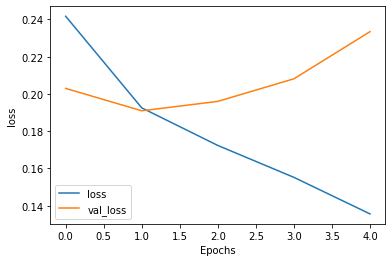

In [ ]:
plot_graphs(history=history, metric='loss')

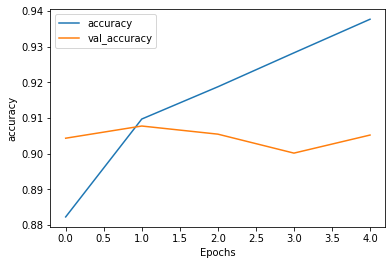

In [ ]:
plot_graphs(history,'accuracy')

In [ ]:
with tf.device('/cpu:0'):
  xtest = tf.data.Dataset.from_tensor_slices((df_pred['SENTENCE'].values, df_pred[labels].values))

In [ ]:
with tf.device('/cpu:0'):
  # test
  xtest = xtest.batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
loss, accuracy = model.evaluate(xtest)

309/309 [==============================] - 102s 331ms/step - loss: 0.2314 - accuracy: 0.9023


In [ ]:
# testing on some samples
sample_example = ["Do you have an adopted dog, how would you encourage people to adopt and not shop?"]
model.predict(sample_example)

array([[1.4011955e-04, 2.4107660e-03, 9.9744910e-01]], dtype=float32)

In [ ]:
sample_example = ["Why do Europeans say they're the superior race, when in fact it took them over 2,000 years until mid 19th century to surpass China's largest economy?"]
model.predict(sample_example)

array([[2.3138053e-03, 6.8122416e-04, 9.9700493e-01]], dtype=float32)

In [ ]:
xtest1 = df_pred['SENTENCE']

In [ ]:
1# predictions by validation data df_test
ypred = model.predict(xtest1.values)
ypred = np.argmax(ypred, axis=1)
ytest = np.argmax(ytest.values, axis=1)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['0','1','2']
print(classification_report(ytest, ypred, target_names = target_names))

              precision    recall  f1-score   support

           0       0.57      0.15      0.23       136
           1       0.52      0.32      0.40       963
           2       0.93      0.98      0.95      8792

    accuracy                           0.90      9891
   macro avg       0.67      0.48      0.53      9891
weighted avg       0.88      0.90      0.89      9891



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, ypred)
print(cm)

[[  20   89   27]
 [  11  309  643]
 [   4  193 8595]]


In [ ]:
ypred[:5]

array([2, 2, 2, 2, 2])

In [ ]:
df_pred['Prediction'] = ypred

In [ ]:
df_pred.tail()

,DOCUMENT_ID,SCORE,SENTENCE,classes_0,classes_1,classes_2,Prediction
70625,689811033,8,The speed in which the process was taken was e...,0,1,0,2
70645,689884033,10,Quick and easy with a low loan interest rate i...,0,0,1,2
70646,689562033,5,The prompt decision,1,0,0,2
70652,689568034,10,paying bills,0,0,1,2
70655,689550034,10,It was quick and easy process,0,0,1,2


# Summary and Improvement:

### 1. Small BERT with only 2 hiden layers, target: 11 scores, reached very high accuracy: train acc 0.963, validation acc 0.962, outperformance CNN/BiLSTM and ANN models! But prediction accuracy is only 0.73, still not good. 
### 2. BERT_Base, target: 3 classes, with uncased inputs, model trainable = True, train acc 0.938, validation acc 0.905. Prediction acc 0.90 which is much improved than small BERT. After 1 epoch shows overfitting.


## Improvement:
### 1. Data quality is very important for neural network models training and prediction. Understand the domain knowledge of dataset, which can help the data preprocessing, such as remove ambiguous data, noise, redundant data etc.

